In [1]:
import json
import torch
import torch.nn.functional as F
import os
import sys
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from pathlib import Path
from loguru import logger
from importlib import reload

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

os.chdir('/home/nico/dev/projects/ai/musai/notebooks')

sys.path.append('../tools')

import tokenizer

reload(tokenizer)

TOKENS_PATH = '/home/nico/data/ai/models/midi/drums/bpe'
TOKENS_FILE_PATHS = list(Path(TOKENS_PATH).glob('*.json'))

In [2]:
device

device(type='cuda', index=0)

In [3]:
TOKENIZER = tokenizer.get_tokenizer(params=f'{TOKENS_PATH}/{tokenizer.TOKEN_PARAMS_NAME}')
PITCHES = [v for k, v in TOKENIZER.vocab.items() if 'Pitch' in k]

2023-06-06 12:49:02.159 | INFO     | tokenizer:get_tokenizer:164 - Tokenizer initialized. Using MMM


In [4]:
logger.info('Semantical processing: {collection_size} documents', collection_size=len(
    TOKENS_FILE_PATHS))

bag_of_hists = []

for token_file in tqdm(list(TOKENS_FILE_PATHS)):
    try:
        tokens = json.load(open(token_file, 'r'))['ids']

        # filter tokens
        tokens = [t for t in tokens if t in PITCHES]
        
        # extract pitch histogram
        tensor = torch.tensor(tokens).to(torch.float)
        tensor_hist = tensor.histc(bins=len(PITCHES))

        bag_of_hists.append(tensor_hist)
    except KeyboardInterrupt:
        break
    except Exception as e:
        logger.error(e)

bag_of_hists = torch.stack(bag_of_hists)
bag_of_hists_normalized = F.normalize(bag_of_hists, dim=0)


2023-06-06 12:49:15.286 | INFO     | __main__:<module>:1 - Semantical processing: 15940 documents
100%|██████████| 15940/15940 [00:49<00:00, 323.96it/s]


In [5]:
pitches_m = torch.stack([torch.mean(v) for v in bag_of_hists_normalized.t()])
distances = torch.FloatTensor([torch.mean((v - pitches_m) ** 2).item()
             for v in bag_of_hists_normalized])

distances

tensor([3.3163e-06, 3.4447e-05, 4.4522e-05,  ..., 2.4555e-05, 6.2397e-05,
        9.5263e-06])

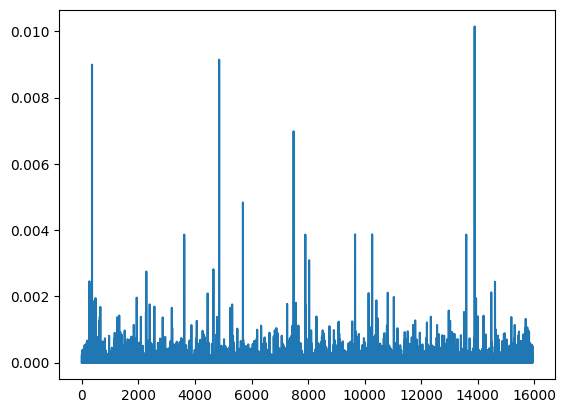

In [6]:
plt.plot(distances)